 # 1. Prep Work

### 1.1 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle # Load refs and annotations
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration 

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np


/home/matea/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Dataset

In [2]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

### 1.2 Load annotations

In [3]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

### 1.3 Dataloader

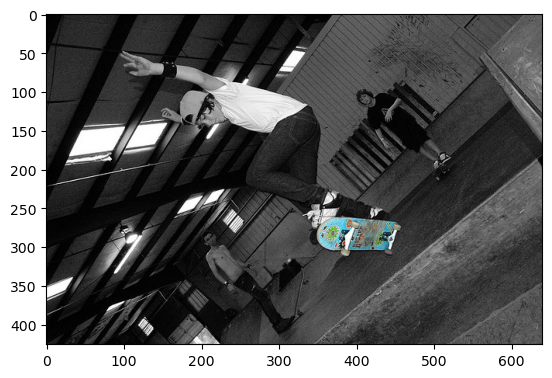

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    #pad_width = padded_width - original_width
    #pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0) #Concatenates a sequence of tensors along a new dimension.

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    
    print(data)
    print("--------------------------")

    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### 1.4 Test Dataset

{'caption': ['Two woman one in black eatting and the other has a white shirt at the desk'], 'ann_id': [1241542], 'bbox': [[0.0, 45.95, 238.92, 408.64]]}
--------------------------
./refcocog/images/COCO_train2014_000000519404.jpg
Two woman one in black eatting and the other has a white shirt at the desk


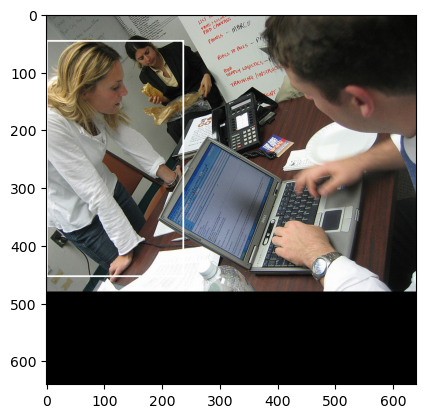

In [28]:
### Usage:
a = 0
for d in dataloader:
    print(dataset[0]['file_name'])
    img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
    bbox = d[1]["bbox"][0]
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)
    print(d[1]["caption"][0])
    plt.imshow(img)
    plt.show()
    if a == 4:
        break
    a += 1

### 1.5 Utils

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

# 2. Baseline

In [9]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [10]:
model, preprocess = clip.load("RN50")
model = model.cuda().eval()

In [11]:
preprocess #List of transformations to apply to images

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fe5979a85e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [29]:
def encode_data(images_fp: list[str], texts: list[str]):
  # preprocess the images to transform from filenames to images to tensors
  images = [preprocess(Image.open(image)) for image in images_fp]

  # preprocess the texts to transform from text to tensors
  images = torch.tensor(np.stack(images)).cuda()
  text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

  # encode the inputs
  with torch.no_grad():
    images_z = model.encode_image(images).float()
    texts_z = model.encode_text(text_tokens).float()
  
  return images_z, texts_z

def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

def get_data():
  a = 0
  images = []
  texts = []

  for d in dataloader:
    texts.append(d[1]["caption"][0])
    if a == 4:
        break
    a += 1
  a = 0
  for d in dataset:
    images.append(d['file_name'])
    if a == 4:
        break
    a += 1
    
  return images, texts

images_fp, texts = get_data()

{'caption': ['Two woman one in black eatting and the other has a white shirt at the desk'], 'ann_id': [1241542], 'bbox': [[0.0, 45.95, 238.92, 408.64]]}
--------------------------
{'caption': ['A TV with a woman being interviewed on it.'], 'ann_id': [33583], 'bbox': [[213.72, 456.51, 192.01, 133.75]]}
--------------------------
{'caption': ['A young boy doing a skateboard trick on a blue board'], 'ann_id': [442348], 'bbox': [[93.82, 45.79, 348.45, 229.75]]}
--------------------------
{'caption': ['A long-horn, long-haired brown cow looking at the camera.'], 'ann_id': [71545], 'bbox': [[39.3, 77.54, 278.76, 216.61]]}
--------------------------
{'caption': ['The woman in black dress.'], 'ann_id': [209158], 'bbox': [[273.07, 144.08, 338.93, 355.4]]}
--------------------------
{'caption': ['A baby elephant standing in front of a larger elephant.'], 'ann_id': [581424], 'bbox': [[59.95, 105.6, 316.98, 245.47]]}
--------------------------
{'caption': ['A bird that is close to the baby in a pi

KeyboardInterrupt: 

In [24]:
images_z, texts_z = encode_data(images_fp, texts)
similarity = cosine_similarity(images_z, texts_z)
print(similarity)

AttributeError: 'Image' object has no attribute 'read'

In [8]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("RN50", device=device)